In [1]:
import torch
from torch.utils.data import DataLoader

import numpy as np
from numpy.linalg import *
import matplotlib.pyplot as plt
import cmath
from scipy import integrate
import os
import h5py
import seaborn as sns


# From this project modules:
from Python.src.LSTM_mudule import LSTM
from Python.src.DataProcessing import Propagator_Dataset

# Enable interactive plot
%matplotlib notebook
color = ['#83b692','#f9ada0', '#f9627d', '#c65b7c', '#5b3758']

# To latex plots:
from matplotlib import rc

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})

In [2]:
from functions import LSTM  # to use the trainined models

# Visualization data generated
___

## Plot Input & Output of data generated

In [17]:
# To load the file

#directory = './DataNew/'
directory = '/home/jessica/Tesis/Paper/data/'
name_data = 'Data_128grid_new2.h5'
 

h5f = h5py.File(directory+name_data, 'r')  # name of file
X_vis = h5f.get('dataset_X')
y_vis = h5f.get('dataset_y')

In [18]:
print('Total of data:',len(X_vis))

Total of data: 3000


In [19]:
X_vis[0][:][0].shape

(384,)

In [20]:
y_vis.shape

(3000, 1000, 256)

In [21]:
# General parameters
n_grid = 128  # number of points on the grid
seq_len = 1000  # number of steps in trajectories
a = -1.5  # initial point in angstroms
b = 1.5  # final point in angstroms

In [22]:
dat = 5# Choosing a data


<IPython.core.display.Javascript object>


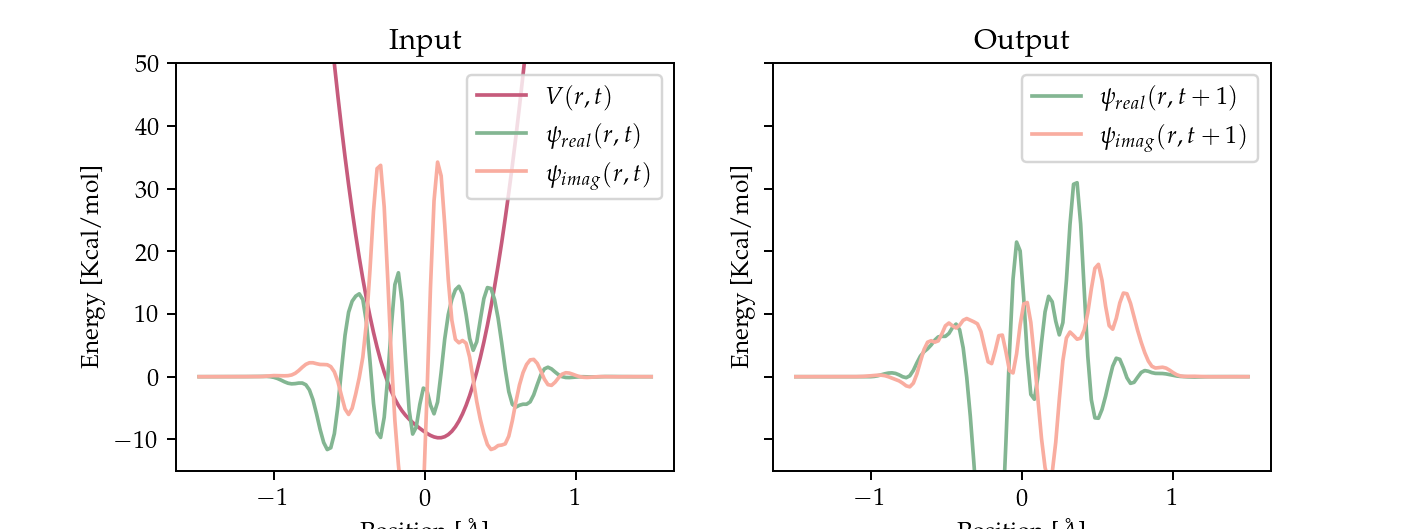

In [23]:
r_n = torch.linspace(a,b,n_grid)
time = int(990)  # Choosing from 0 to seq_len -1

In_real_vis = X_vis[dat,time,0:n_grid]
In_imag_vis = X_vis[dat,time,n_grid:n_grid*2]
In_pote = X_vis[dat,time,n_grid*2:n_grid*3]

Ou_real_vis = y_vis[dat,time,0:n_grid]
Ou_imag_vis = y_vis[dat,time,n_grid:n_grid*2]


fig, axs = plt.subplots(1,2)


# Lenght: au -> Angstroms & au -> kcal/mol
axs[0].plot(r_n, In_pote*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0].plot(r_n, In_real_vis*30, label="$\psi_{real}(r, t)$", color = color[0])  # Escaled
axs[0].plot(r_n, In_imag_vis*30, label="$\psi_{imag}(r, t)$", color=color[1])  # Escaled
axs[0].set_title("Input")

axs[1].plot(r_n, (In_real_vis + Ou_real_vis)*30, label="$\psi_{real}(r, t+1)$", color = color[0])  # Escaled
axs[1].plot(r_n, (In_imag_vis +Ou_imag_vis)*30, label="$\psi_{imag}(r, t+1)$", color = color[1])  # Escaled
axs[1].set_title("Output")


for ax in axs.flat:
    ax.label_outer()
    ax.set_ylim([-15, 50])
    ax.legend()
    ax.set(xlabel='Position [$\AA$]', ylabel='Energy [Kcal/mol]')

plt.gcf().set_size_inches(8, 3)
ax.legend()
plt.show()

## Wavefunction through time visualization

In [24]:
r_n = torch.linspace(a,b,n_grid)

X_r = X_vis[dat,:,0:n_grid].T
X_i = X_vis[dat,:,n_grid:2*n_grid].T
X_de = np.vectorize(complex)(X_r,X_i)

X_dens = ((np.abs(X_de))**2)

<IPython.core.display.Javascript object>


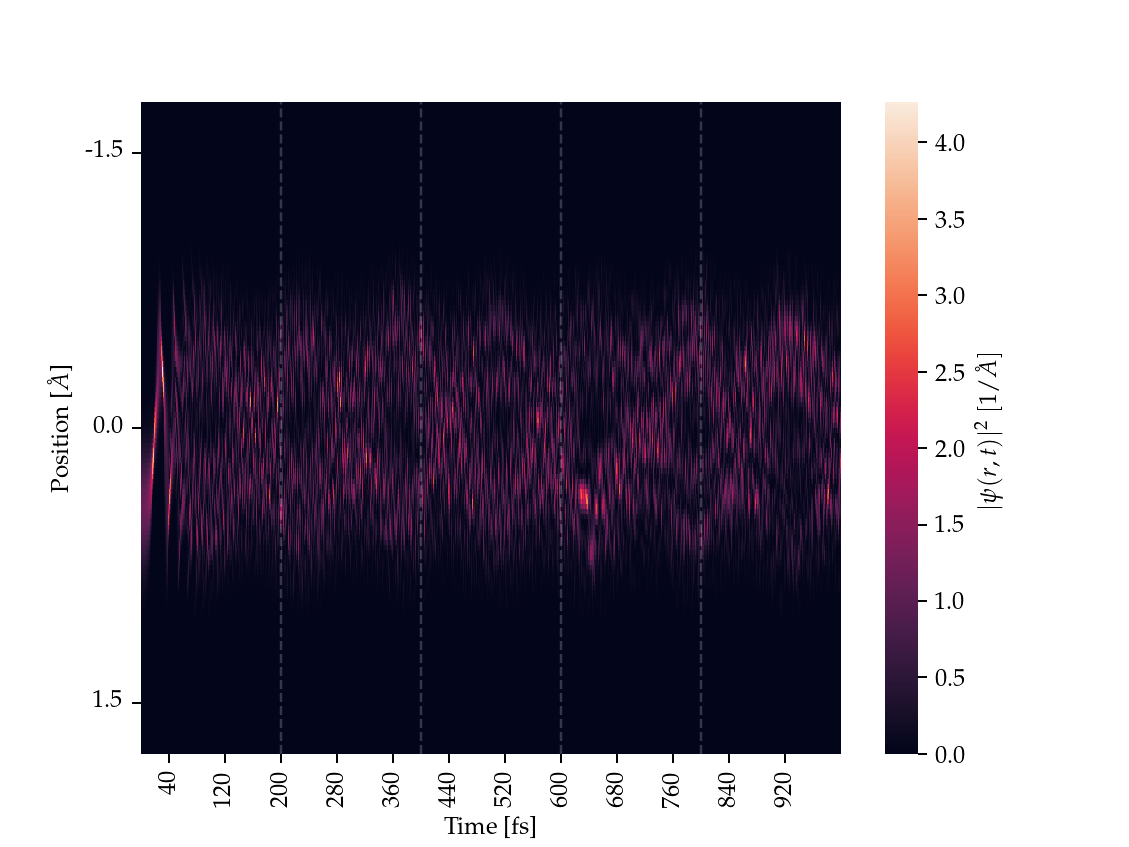

In [25]:
fig, ax = plt.subplots()

ax = sns.heatmap(X_dens, square=False, cbar_kws={'label': '$|\psi(r,t)|^2$ $[1/\AA]$'})
ax.set_xticks(range(40, 1000, 80))
ax.set_xticklabels(c for c in np.arange(40, 1000, 80))

ax.set_yticks(range(10, 119, 54))
ax.set_yticklabels(f'{c:.1f}' for c in np.arange(-1.5, 1.6, 1.5))

# Add vertical lines at specified times
for t in [200, 400, 600, 800]:
    ax.axvline(x=t, color='white', linestyle='--', linewidth=1, alpha=0.2)

plt.xlabel("Time [fs]") 
plt.ylabel("Position [$\AA$]") 
plt.show()
#plt.gcf().set_size_inches(6, 4)
#plt.savefig('/home/jessica/Tesis/Paper/img/trajectory_data7.png', dpi=500)

## Potential through time visualization

<IPython.core.display.Javascript object>


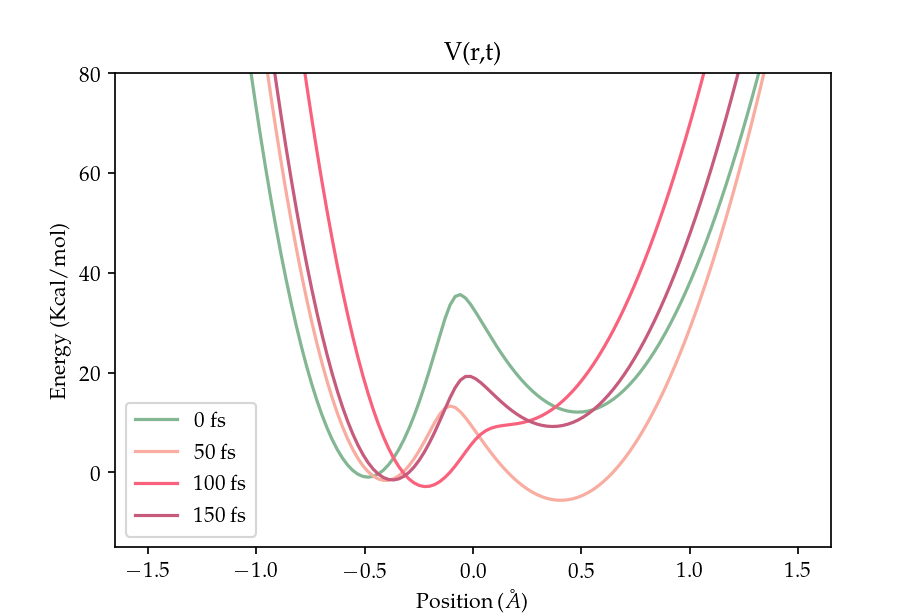

In [37]:
fig, ax = plt.subplots()
ax.set_title(r"V(r,t)")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('Energy (Kcal/mol)')
ax.set_ylim([-15,80])

# Time: fs -> au, Lenght: au -> Angstroms, Energy: au -> kcal/mol
ax.plot(r_n, X_vis[dat,0,n_grid*2:n_grid*3]*(1/1.5936e-3), "-", label="0 fs", color=color[0])
ax.plot(r_n, X_vis[dat,200,n_grid*2:n_grid*3]*(1/1.5936e-3), "-", label="50 fs", color=color[1])
ax.plot(r_n, X_vis[dat,400,n_grid*2:n_grid*3]*(1/1.5936e-3), "-", label="100 fs", color=color[2])
ax.plot(r_n, X_vis[dat,900,n_grid*2:n_grid*3]*(1/1.5936e-3), "-", label="150 fs", color=color[3])
ax.legend()
plt.show()
plt.gcf().set_size_inches(6, 4)
#plt.savefig('/home/jessica/Tesis/Paper/img/ExamplesPotential_data7.pdf')


## Initial wavepacket

<IPython.core.display.Javascript object>


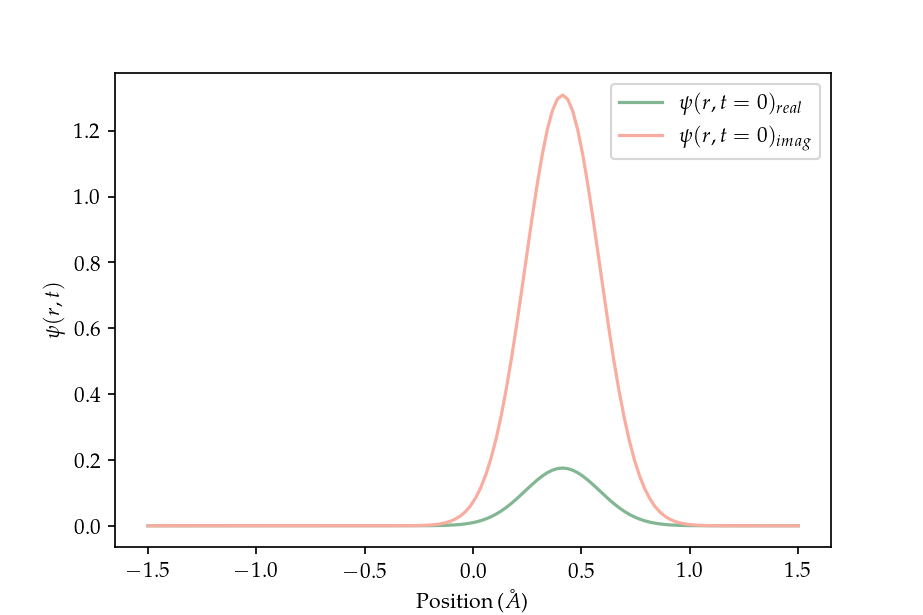

In [38]:
time = int(0)  # Choosing from 0 to seq_len -1

In_real_vis = X_vis[dat,time,0:n_grid]
In_imag_vis = X_vis[dat,time,n_grid:n_grid*2]

fig, ax = plt.subplots()
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\psi(r,t)$')

# Lenght: au -> Angstroms
ax.plot(r_n, In_real_vis, label="$\psi(r, t=0)_{real}$", color=color[0])
ax.plot(r_n, In_imag_vis, label="$\psi(r, t=0)_{imag}$", color=color[1])
plt.gcf().set_size_inches(6, 4)
ax.legend()
#plt.savefig('/home/jessica/Tesis/Paper/img/psi_0_data7.pdf')
plt.show()

<IPython.core.display.Javascript object>


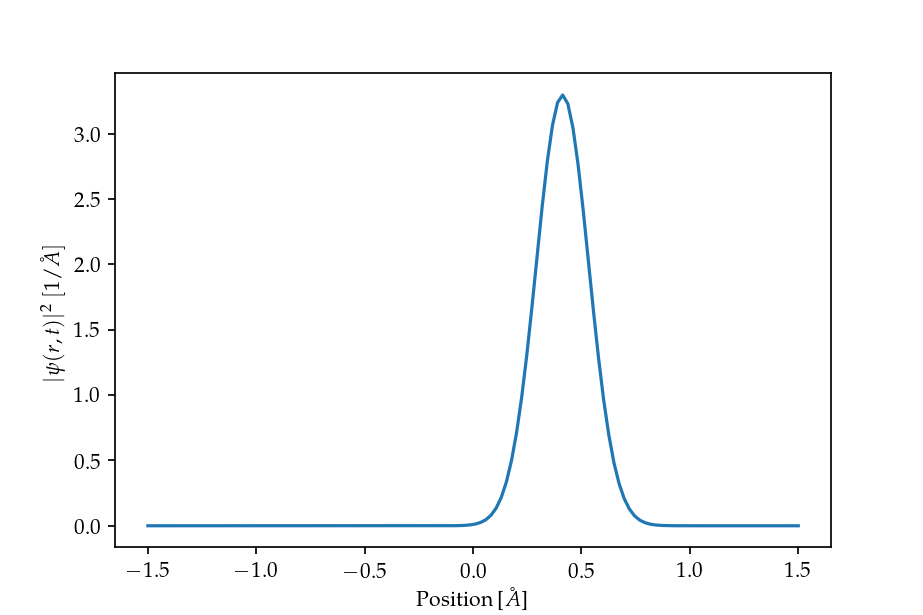

In [39]:
r_n = np.linspace(a,b,n_grid)
X_de = np.vectorize(complex)(In_real_vis*np.sqrt(1/0.5291775),In_imag_vis*np.sqrt(1/0.5291775))
X_dens = ((np.abs(X_de))**2)


fig, ax = plt.subplots()
ax.plot(r_n, X_dens)
ax.set(xlabel='Position [$\AA$]', ylabel='$|\psi(r,t)|^2$   $[1/\AA]$')
plt.gcf().set_size_inches(6, 4)
#plt.savefig('/home/jessica/Tesis/Paper/img/dens_0_data7.pdf')
plt.show()

In [40]:
integrate.simpson(X_dens,r_n)

1.0000000000000002

## Checking normalization of wave packet at random time t

### [a.u.]

<IPython.core.display.Javascript object>


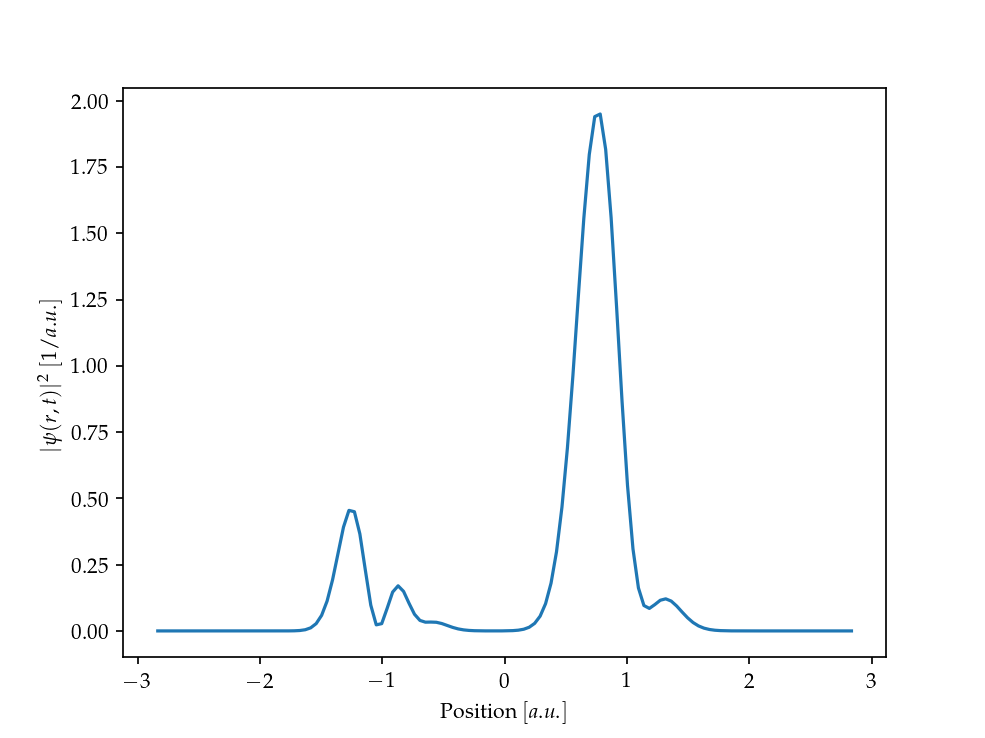

In [41]:
r_n = np.linspace(a,b,n_grid)*(1/0.5291775)  # angstroms to au
time = int(100)

X_r = X_vis[dat,time,0:n_grid]
X_i = X_vis[dat,time,n_grid:2*n_grid]
X_de = np.vectorize(complex)(X_r,X_i)
X_dens = ((np.abs(X_de))**2)


fig, ax = plt.subplots()
ax.plot(r_n, X_dens)
ax.set(xlabel='Position $[a.u.]$', ylabel='$|\psi(r,t)|^2$   $[1/a.u.]$')
plt.show()

In [42]:
integrate.simpson(X_dens,r_n)

1.0000000000003553

### [$Å$]

<IPython.core.display.Javascript object>


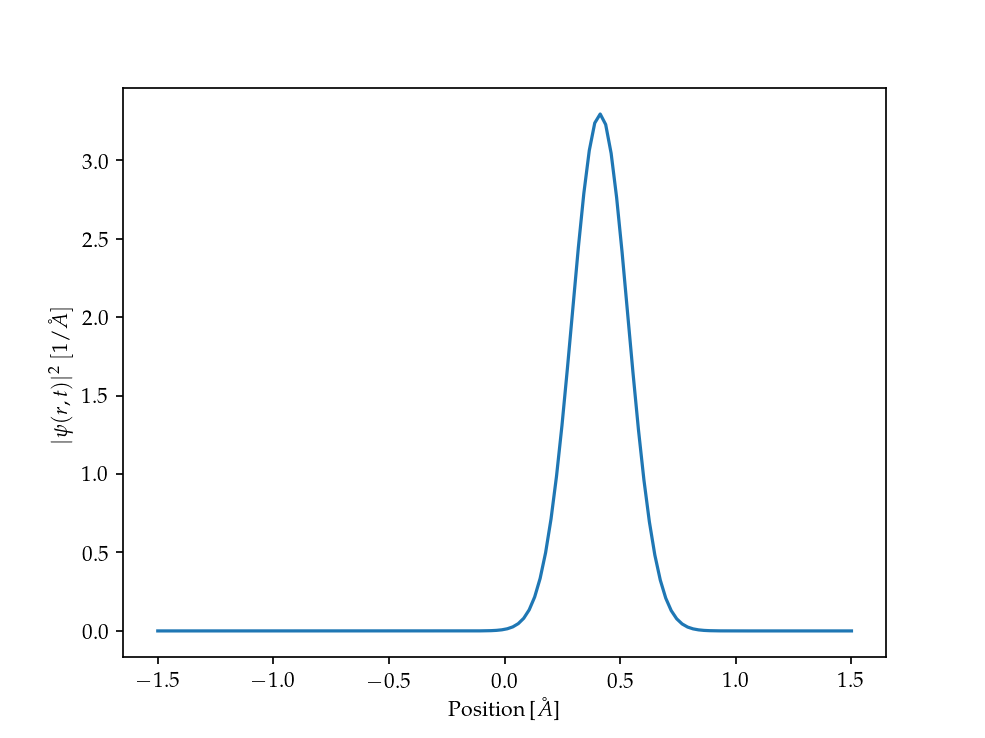

In [43]:
r_n = np.linspace(a,b,n_grid)
time = int(0)

X_r = X_vis[dat,time,0:n_grid]*np.sqrt(1/0.5291775)
X_i = X_vis[dat,time,n_grid:2*n_grid]*np.sqrt(1/0.5291775)
X_de = np.vectorize(complex)(X_r,X_i)
X_dens = ((np.abs(X_de))**2)# or *(1/0.5291775)


fig, ax = plt.subplots()
ax.plot(r_n, X_dens)
ax.set(xlabel='Position [$\AA$]', ylabel='$|\psi(r,t)|^2$   $[1/\AA]$')
plt.show()

In [44]:
integrate.simpson(X_dens,r_n)

1.0000000000000002

# Predicted data visualization and comparisons
___

## Plot comparison LSTM predictions vs DVR

In [31]:
n_grid = 128

In [26]:
test_path_dat = directory+name_data

In [27]:
dataset = Propagator_Dataset(path=test_path_dat, data='dataset_X', targets='dataset_y')

In [28]:
batch_size = 10

In [29]:
test_loader = DataLoader(dataset, batch_size=batch_size)

In [30]:
for X, y in test_loader:
    print("Test data:")
    print(f"Shape of X in test loader: {X.shape}")
    print(f"Shape of y in test loader: {y.shape}")
    print(f"Batch size: {X.size(0)}")
    break

Test data:
Shape of X in test loader: torch.Size([10, 1000, 384])
Shape of y in test loader: torch.Size([10, 1000, 256])
Batch size: 10


In [31]:
# Calling the trained model
device = 'cpu'
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_5040trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))

# if cuda is available uncomment:
#model = torch.load('/home/jessica/Documentos/Trained_LSTM_Models/model5b.pth')

In [66]:
for X,y in test_loader:
    X, y = X.to(device), y.to(device)
    
    Input = X
    
    Output = y

    with torch.inference_mode():
        Prediction = model(X.float())
    break

In [67]:
print(Input.shape)
print(Prediction.shape)
print(Output.shape)

torch.Size([10, 1000, 384])
torch.Size([10, 1000, 256])
torch.Size([10, 1000, 256])


In [73]:
r_n = torch.linspace(a,b,n_grid)
dat=2

X_r = Output[dat,:,0:n_grid].T
X_i = Output[dat,:,n_grid:2*n_grid].T
X_de = np.vectorize(complex)(X_r,X_i)

X_dens = ((np.abs(X_de))**2)

<IPython.core.display.Javascript object>


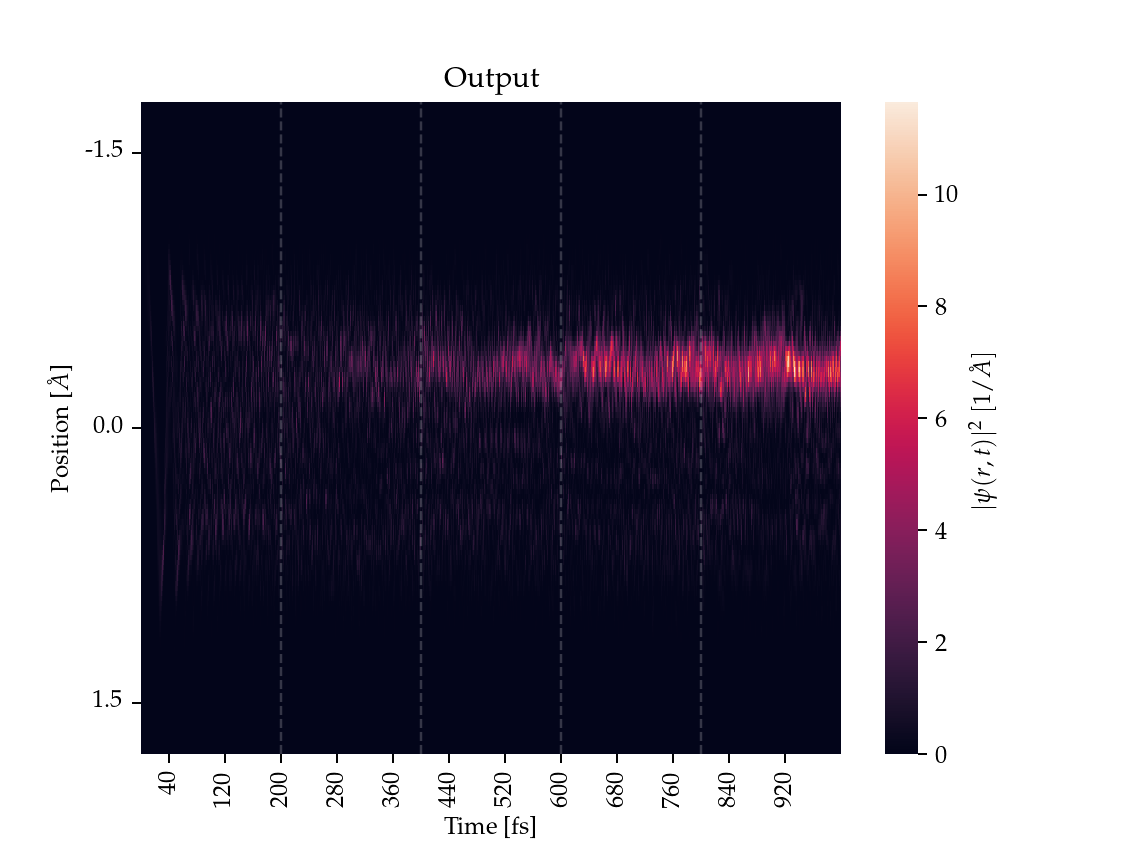

In [74]:
fig, ax = plt.subplots()

ax = sns.heatmap(X_dens, square=False, cbar_kws={'label': '$|\psi(r,t)|^2$ $[1/\AA]$'})
ax.set_title('Output')

ax.set_xticks(range(40, 1000, 80))
ax.set_xticklabels(c for c in np.arange(40, 1000, 80))

ax.set_yticks(range(10, 119, 54))
ax.set_yticklabels(f'{c:.1f}' for c in np.arange(-1.5, 1.6, 1.5))

# Add vertical lines at specified times
for t in [200, 400, 600, 800]:
    ax.axvline(x=t, color='white', linestyle='--', linewidth=1, alpha=0.2)

plt.xlabel("Time [fs]") 
plt.ylabel("Position [$\AA$]") 
plt.show()

In [75]:
r_n = torch.linspace(a,b,n_grid)

X_r = Prediction[dat,:,0:n_grid].T
X_i = Prediction[dat,:,n_grid:2*n_grid].T
X_de = np.vectorize(complex)(X_r,X_i)

X_dens = ((np.abs(X_de))**2)

<IPython.core.display.Javascript object>


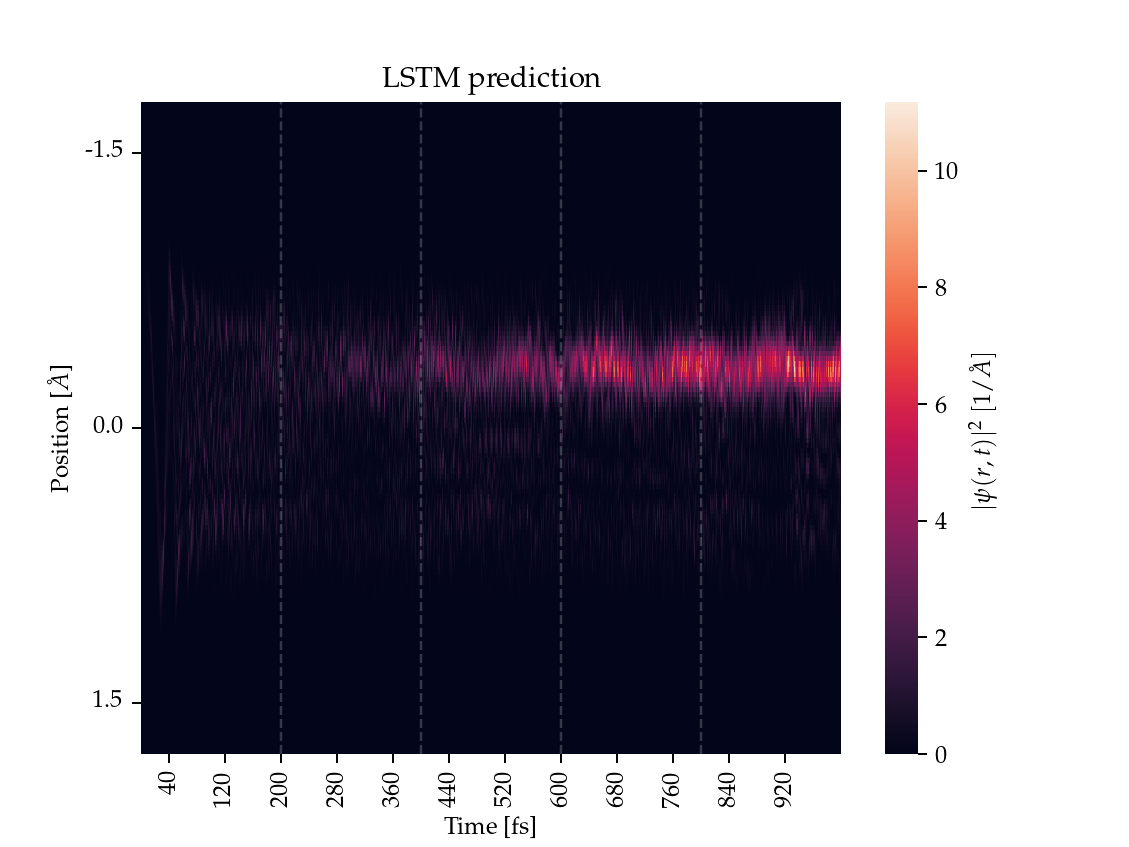

In [76]:
fig, ax = plt.subplots()

ax = sns.heatmap(X_dens, square=False, cbar_kws={'label': '$|\psi(r,t)|^2$ $[1/\AA]$'})
ax.set_title('LSTM prediction')
ax.set_xticks(range(40, 1000, 80))
ax.set_xticklabels(c for c in np.arange(40, 1000, 80))

ax.set_yticks(range(10, 119, 54))
ax.set_yticklabels(f'{c:.1f}' for c in np.arange(-1.5, 1.6, 1.5))

# Add vertical lines at specified times
for t in [200, 400, 600, 800]:
    ax.axvline(x=t, color='white', linestyle='--', linewidth=1, alpha=0.2)

plt.xlabel("Time [fs]") 
plt.ylabel("Position [$\AA$]") 
plt.show()

## Real and Complex parts of wavefunction comparison

In [77]:
def wavefunction(part, time, source):
    
    if source == 'input':
        if part == 'real':
            in_real_t = Input[dat,time,0:n_grid].detach().numpy()
            return in_real_t
        
        if part == 'complex':
            in_imag_t = Input[dat,time,n_grid:n_grid*2].detach().numpy()
            return in_imag_t
        
        
    if source == 'output':
        if part == 'real':
            ou_real_t = Output[dat,time,0:n_grid].detach().numpy()
            return ou_real_t
        
        if part == 'complex':
            ou_imag_t = Output[dat,time,n_grid:n_grid*2].detach().numpy()
            return ou_imag_t
        
    if source == 'prediction':
        if part == 'real':
            pred_real_t = Prediction[dat,time,0:n_grid].detach().numpy()
            return pred_real_t
        
        if part == 'complex':
            pred_imag_t = Prediction[dat,time,n_grid:n_grid*2].detach().numpy()
            return pred_imag_t

In [78]:
def potential(time):
    pot = Input[dat,time,n_grid*2:n_grid*3].detach().numpy()
    return pot

<IPython.core.display.Javascript object>


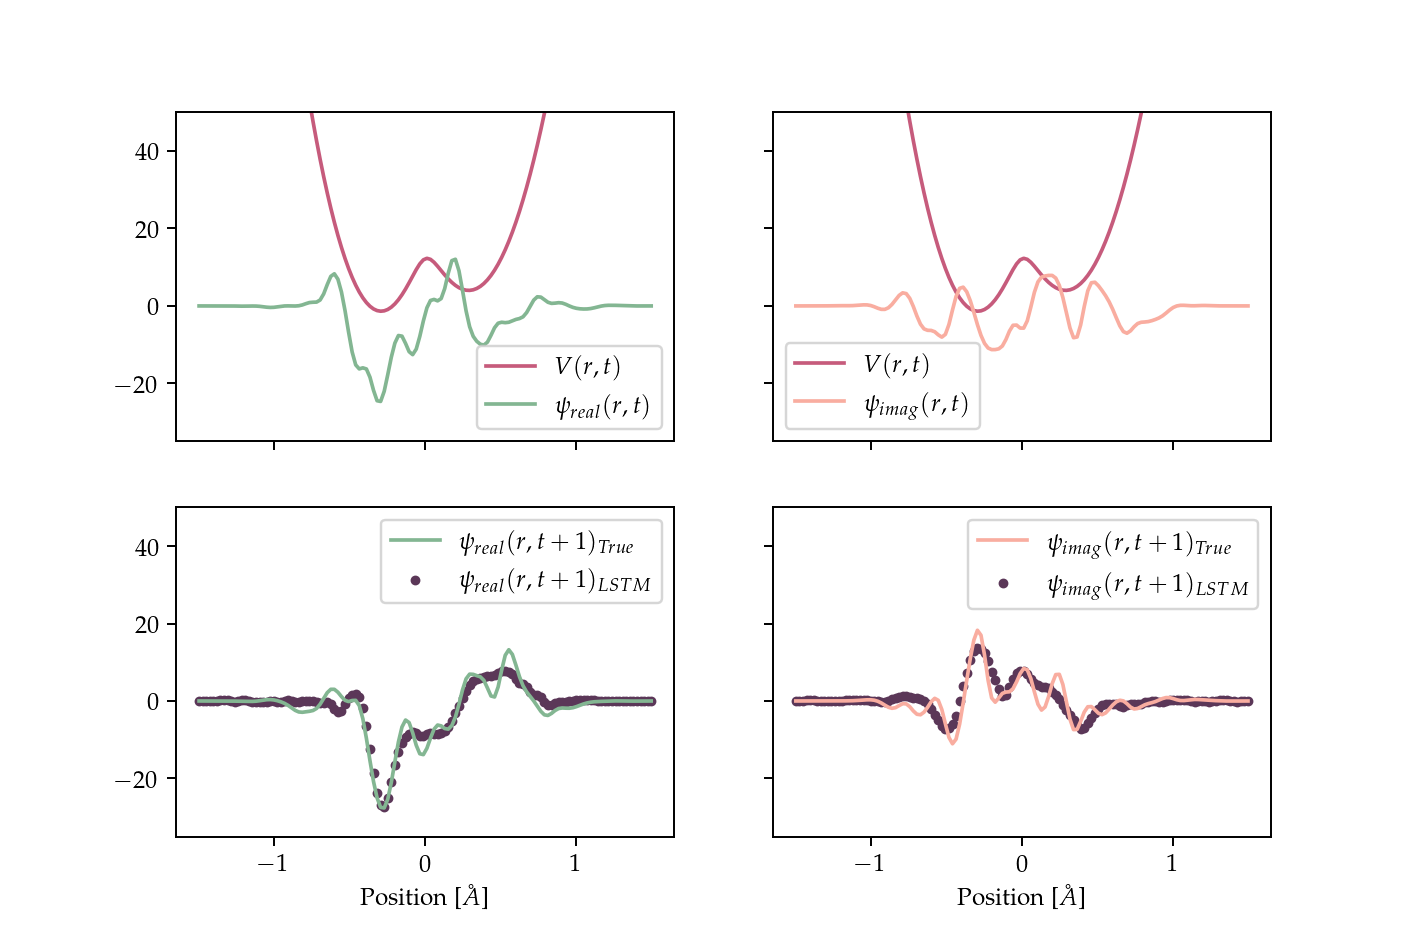

In [86]:
fig, axs = plt.subplots(2,2)
time = int(200)
r_n = np.linspace(a,b,n_grid)

# Lenght: au -> Angstroms
axs[0,0].plot(r_n, potential(time)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,0].plot(r_n, wavefunction('real', time, 'input')*20, label="$\psi_{real}(r, t)$", color=color[0])  # Escaled


axs[0,1].plot(r_n, potential(time)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,1].plot(r_n, wavefunction('complex', time, 'input')*20, label="$\psi_{imag}(r, t)$", color =color[1])  # Escaled

#axs[0].plot(r_n, Pote_next*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
axs[1,0].plot(r_n, (wavefunction('real', time, 'output')+wavefunction('real', time, 'input'))*20, label="$\psi_{real}(r, t+1)_{True}$", color=color[0])  # Escaled
axs[1,0].scatter(r_n, (wavefunction('real', time, 'prediction')+wavefunction('real', time, 'input'))*20, label="$\psi_{real}(r, t+1)_{LSTM}$", color=color[4], marker='.')  # Escaled
 

axs[1,1].plot(r_n, (wavefunction('complex', time, 'output')+wavefunction('complex', time, 'input'))*20, label="$\psi_{imag}(r, t+1)_{True}$", color =color[1])  # Escaled
axs[1,1].scatter(r_n, (wavefunction('complex', time, 'prediction')+wavefunction('complex', time, 'input'))*20, label="$\psi_{imag}(r, t+1)_{LSTM}$", color =color[4], marker='.')  # Escaled


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_ylim([-35,50])
    ax.legend()
    ax.set(xlabel='Position [$\AA$]')
    ax.label_outer()
    pass
 
plt.gcf().set_size_inches(8, 5.33)
plt.legend()    
plt.show()

## Density comparison

In [80]:
def density(time, source):
    
    if time == 0:
        dens = (np.abs(np.vectorize(complex)(wavefunction('real',time,'input'),wavefunction('complex', time, 'input'))))**2
        return dens
    
    if source == 'output':
        Ou_dens_t = (np.abs(np.vectorize(complex)(wavefunction('real',time,source),wavefunction('complex', time, source))))**2
        return Ou_dens_t
    
    if source == 'prediction':
        Ou_dens_t = (np.abs(np.vectorize(complex)(wavefunction('real',time,source),wavefunction('complex', time, source))))**2
        return Ou_dens_t

<IPython.core.display.Javascript object>


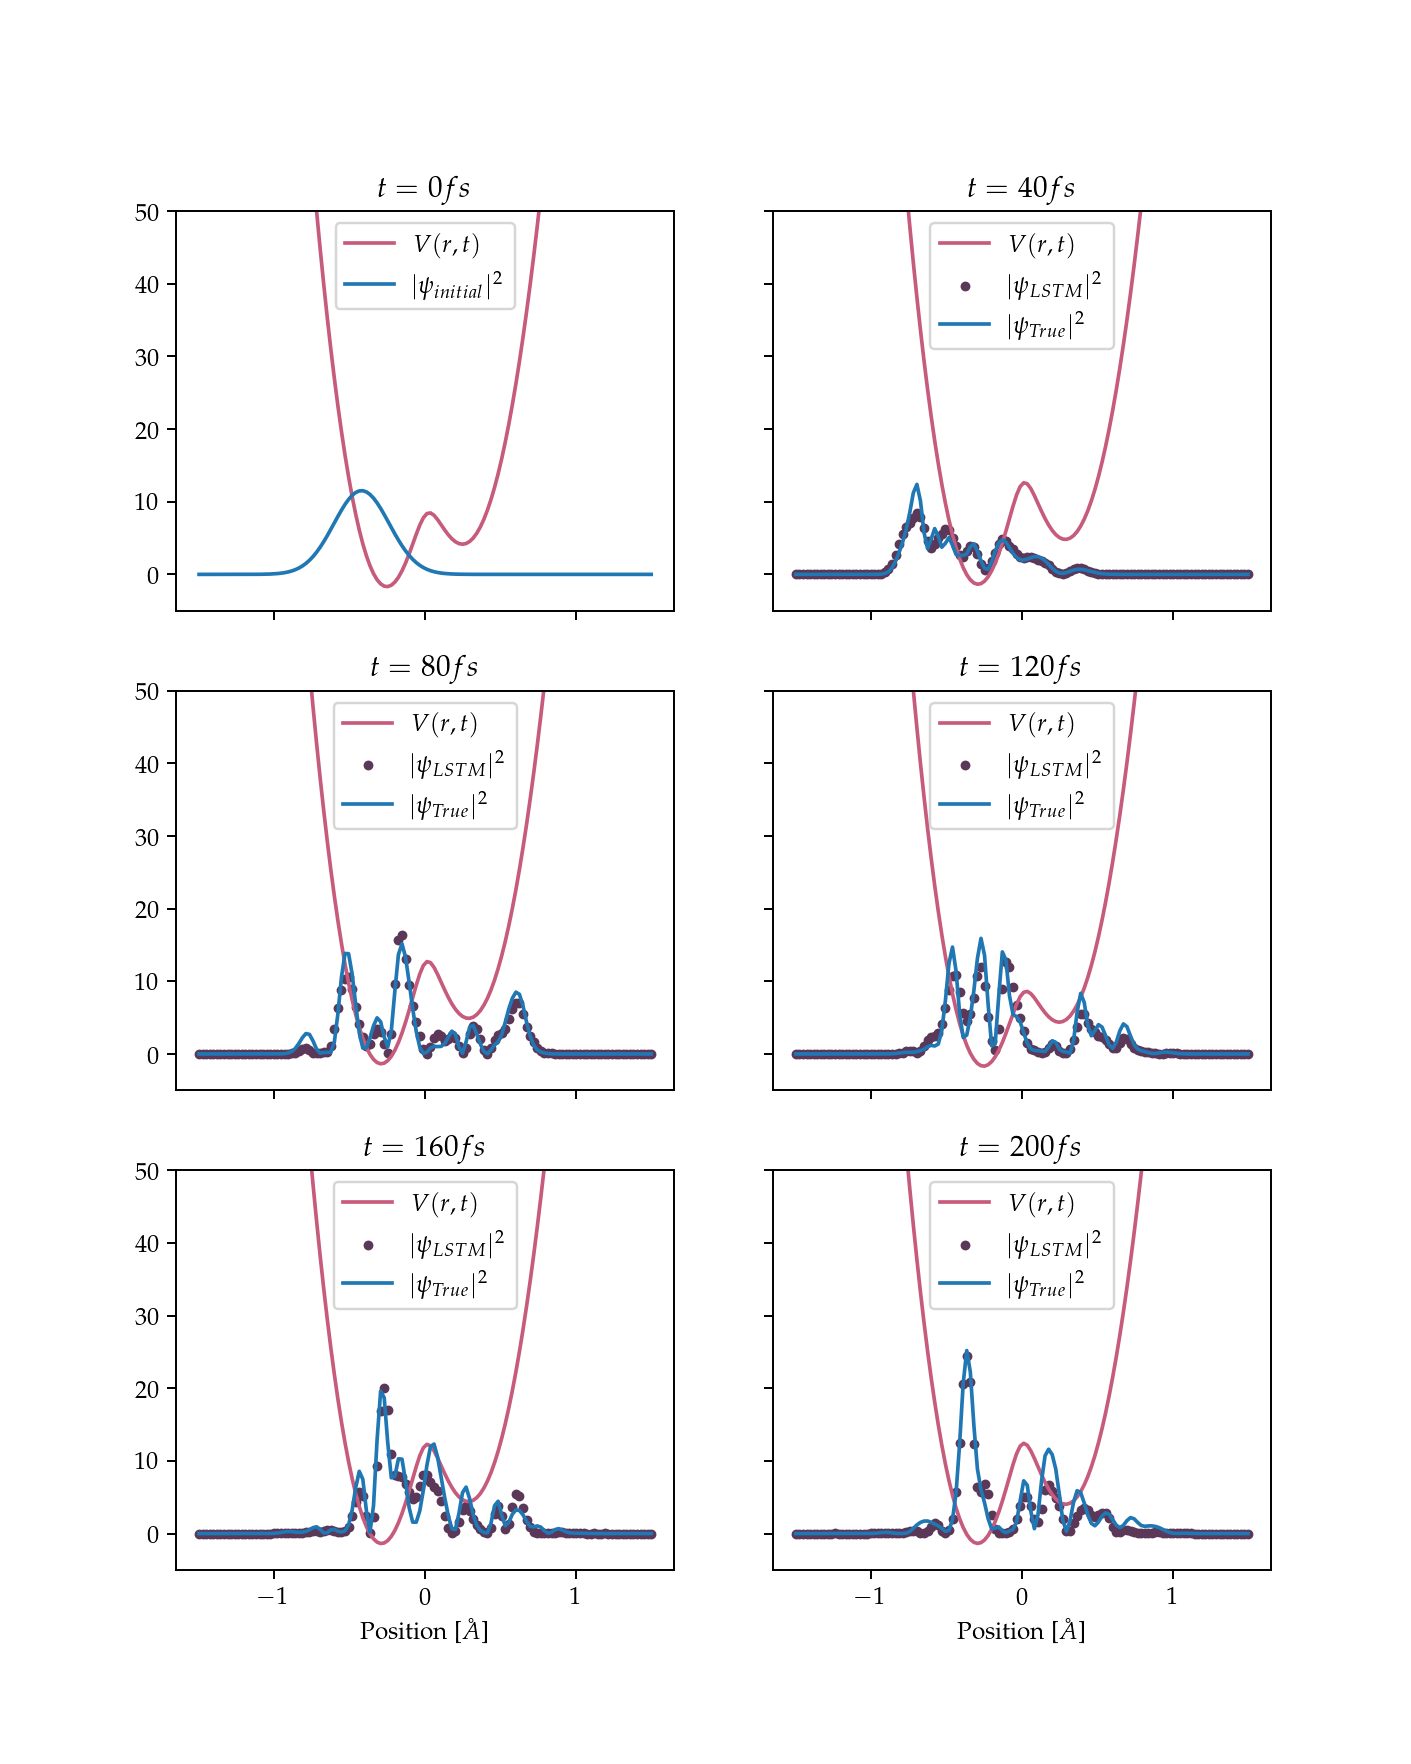

In [81]:
fig, ax = plt.subplots(3,2)

    
# Time: fs -> au, Lenght: au -> Angstroms, Energy: au -> kcal/mol

# t = 0
ax[0,0].plot(r_n, potential(0)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[0,0].plot(r_n, density(0, 'output')*10, label="$|\psi_{initial}|^{2}$")
ax[0,0].set_title("$t=0 fs$")

# t = 40
ax[0,1].plot(r_n, potential(40)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[0,1].scatter(r_n, density(40, 'prediction')*10, label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[0,1].plot(r_n, density(40, 'output')*10, label="$|\psi_{True}|^{2}$")
ax[0,1].set_title("$t=40 fs$")

# t = 80
ax[1,0].plot(r_n, potential(80)*(1/1.5936e-3), "-", label="$V(r, t)$", color=color[3])
ax[1,0].scatter(r_n, density(80, 'prediction')*10, label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[1,0].plot(r_n, density(80, 'output')*10, label="$|\psi_{True}|^{2}$")
ax[1,0].set_title("$t=80 fs$")

# t = 120
ax[1,1].plot(r_n, potential(120)*(1/1.5936e-3), "-", label="$V(r, t)$", color=color[3])
ax[1,1].scatter(r_n, density(120,'prediction')*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[1,1].plot(r_n, density(120,'output')*10, label="$|\psi_{True}|^{2}$")
ax[1,1].set_title("$t=120 fs$")

# t = 160
ax[2,0].plot(r_n, potential(160)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[2,0].scatter(r_n, density(160,'prediction')*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[2,0].plot(r_n, density(160, 'output')*10, label="$|\psi_{True}|^{2}$")
ax[2,0].set_title("$t=160 fs$")

# t = 200
ax[2,1].plot(r_n, potential(199)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[2,1].scatter(r_n, density(199, 'prediction')*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[2,1].plot(r_n, density(199, 'output')*10, label="$|\psi_{True}|^{2}$")
ax[2,1].set_title("$t=200 fs$")







for axr1 in ax:
    for axr11 in axr1:
        axr11.set_ylim([-5, 50])
        axr11.legend()
        axr11.set(xlabel='Position [$\AA$]')
        
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in ax.flat:
    ax.label_outer()
    
    
plt.gcf().set_size_inches(8, 10)
#plt.legend()    
plt.show()

## Calculating accuracy

In [93]:
from torch import nn
criterion = nn.MSELoss().to(device)

In [105]:
def S_overlap(Psi_true, Psi_ANN, X):
    """
    Input:
    Psi_true: Evolution of wavepacket from dataset test, Shape: (batch size, sequence lenght, 64)
    Psi_ANN: Evolution of wavepacket predicted with the model, Shape: (batch size, sequence lenght, 64)
    X : Evolution of wavepacket at time t-1
    
    Output:
    S: Absolute magnitude
    angle: phase
    Characterizes the quality of the predictions. See equation (11) of Main article

    """
    
    Psi_true_re = Psi_true[:,:,0:n_grid] + X[:,:,0:n_grid]   # realpart of wavepacket predicted
    Psi_true_im = Psi_true[:,:,n_grid:n_grid*2] + X[:,:,n_grid:n_grid*2]  # imaginary part of wavepacket predicted 
    Psi_t = torch.view_as_complex(torch.stack((Psi_true_re,Psi_true_im), -1)).to(device)
    
    Psi_ANN_re = Psi_ANN[:,:,0:n_grid]+ X[:,:,0:n_grid]  # realpart of wavepacket predicted
    Psi_ANN_im = -(Psi_ANN[:,:,n_grid:n_grid*2]+ X[:,:,n_grid:n_grid*2])  # imaginary part of wavepacket predicted (- because conjugate)
    Psi_A = torch.view_as_complex(torch.stack((Psi_ANN_re,Psi_ANN_im), -1)).to(device)
    
    overl = Psi_A*Psi_t
    
    # Integrate over r (real integral + complex integral)
    # Trapezoid method in the grid r_n (angstroms -> au)
    
    r_n = (torch.linspace(-1.5,1.5,n_grid)*(1/0.5291775)).to(device)
    overl_real = overl.real
    overl_imag = overl.imag
    
    real_integ = torch.trapz(overl_real, r_n).to(device)
    imag_integ = torch.trapz(overl_imag, r_n).to(device)
    
    # Covert to phase and magnitude of the complex result
    S =  torch.sqrt(real_integ**2 + imag_integ**2).to(device)
    angle = torch.arctan(imag_integ/real_integ).to(device)
    
    # Mean S & angle
    S = torch.sum(S)/(batch_size*seq_len)
    angle = torch.sum(angle)/(batch_size*seq_len)
    
    
    return S, angle

In [106]:
def test1(dataloader, model, loss_fn):
    '''
    Same as test function but without writer to tensorboard
    '''
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correctS, correct_phase = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            S, angle = S_overlap(y,pred,X)  
            correctS += S
            correct_phase += angle
    
    correctS /= num_batches
    correct_phase /= num_batches

    print(f"Test Error: \n Accuracy Magnitude |S|: {(100*correctS):>0.1f}%")
    print(f"Test Error: \n Accuracy phase: {(correct_phase):>0.1f}\n")

## Models accuracy  
- grid points = 128  
- trajectories of 1000 fs

In [ ]:
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_5040trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))

In [107]:
# model: 09-09-2024_1000fs_5040trainsamples.pth
test1(test_loader, model, criterion)

Test Error: 
 Accuracy Magnitude |S|: 73.5%
Test Error: 
 Accuracy phase: 0.0



In [108]:
# model: 09-09-2024_1000fs_1260trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_1260trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_1260trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_1260trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 70.0%
Test Error: 
 Accuracy phase: -0.0



In [109]:
# model: 09-09-2024_1000fs_1890trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_1890trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_1890trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_1890trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 71.3%
Test Error: 
 Accuracy phase: -0.0



In [116]:
# model: 09-09-2024_1000fs_2520trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_2520trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_2520trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_2520trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 71.8%
Test Error: 
 Accuracy phase: 0.0



In [115]:
# model: 09-09-2024_1000fs_3150trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_3150trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_3150trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_3150trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 72.6%
Test Error: 
 Accuracy phase: -0.0



In [114]:
# model: 09-09-2024_1000fs_3780trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_3780trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_3780trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_3780trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 73.1%
Test Error: 
 Accuracy phase: -0.0



In [113]:
# model: 09-09-2024_1000fs_4410trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_4410trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_4410trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_4410trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 73.1%
Test Error: 
 Accuracy phase: 0.0



In [112]:
# model: 09-09-2024_1000fs_5670trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_5670trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_5670trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_5670trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 73.1%
Test Error: 
 Accuracy phase: 0.0



In [111]:
# model: 09-09-2024_1000fs_6300trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_6300trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_6300trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_6300trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 73.4%
Test Error: 
 Accuracy phase: -0.0



In [110]:
# model: 09-09-2024_1000fs_630trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_630trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_630trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_630trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 67.3%
Test Error: 
 Accuracy phase: 0.0



## Results

### Accuracy calculated using Data_128grid_new2.h5 and eq. 11 absolute magnitude |S| ($\theta=0.0$) all models
- Total of data: 3000
- grid points = 128  
- trajectories of 1000 fs


|Model|$|S|$|
|:----|----|
|09-09-2024_1000fs_5040trainsamples.pth|73.5%|
|09-09-2024_1000fs_1260trainsamples.pth|70.0%|
|09-09-2024_1000fs_1890trainsamples.pth|73.5%|
|09-09-2024_1000fs_1260trainsamples.pth|70.0%|
|09-09-2024_1000fs_1890trainsamples.pth|71.3%|
|09-09-2024_1000fs_2520trainsamples.pth|71.8%|
|09-09-2024_1000fs_3150trainsamples.pth|72.6%|
|09-09-2024_1000fs_3780trainsamples.pth|73.1%|
|09-09-2024_1000fs_4410trainsamples.pth|73.1%|
|09-09-2024_1000fs_5670trainsamples.pth|73.1%|
|09-09-2024_1000fs_6300trainsamples.pth|73.4%|
|09-09-2024_1000fs_630trainsamples.pth|67.3%|

